# Import Library

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os 
from datetime import datetime 
import pandas as pd
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from sklearn.ensemble import IsolationForest

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
df=pd. read_csv('/content/drive/My Drive/Colab Notebooks/FPS/81250_202302_BeltCurrent.csv', engine='python', encoding='utf-8', error_bad_lines=False)
df

,floatvalue,t_stamp
0,17.992546,1675209793867
1,18.385374,1675209813868
2,18.549816,1675209833869
3,18.448912,1675209853870
4,18.515699,1675209873872
...,...,...
60483,19.219530,1677628600856
60484,19.165195,1677628640859
60485,19.222761,1677628660861
60486,19.225843,1677628680863


In [ ]:
df.index.freq="MS"
df['t_stamp']= pd.to_datetime(df['t_stamp'], unit='ms') ##, unit='ms'
#df=df.iloc[3535:9200]
df

,floatvalue,t_stamp
0,17.992546,2023-02-01 00:03:13.867
1,18.385374,2023-02-01 00:03:33.868
2,18.549816,2023-02-01 00:03:53.869
3,18.448912,2023-02-01 00:04:13.870
4,18.515699,2023-02-01 00:04:33.872
...,...,...
60483,19.219530,2023-02-28 23:56:40.856
60484,19.165195,2023-02-28 23:57:20.859
60485,19.222761,2023-02-28 23:57:40.861
60486,19.225843,2023-02-28 23:58:00.863


In [ ]:
csv_data = df.to_csv('81250MLPredict_March15_V4.csv',sep= ',')

<Axes: >

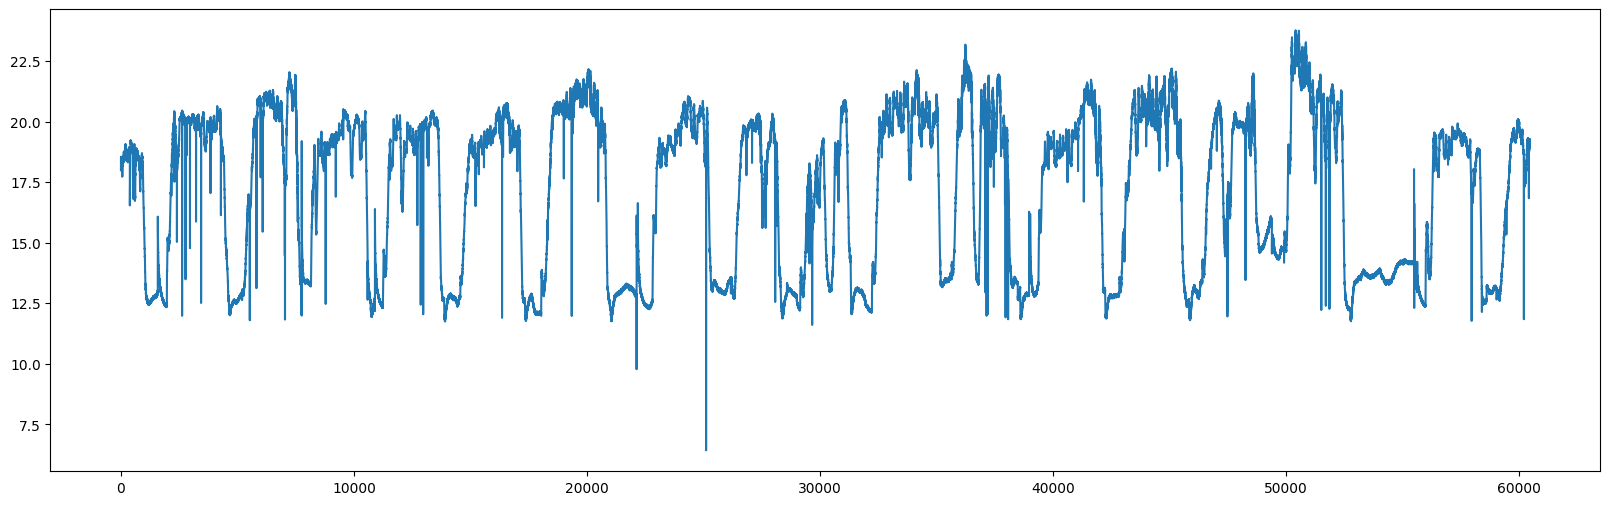

In [ ]:
df['floatvalue'].plot(figsize=(20,6))

In [ ]:
count = (df['floatvalue'] == 0).sum()
print('Count of zeros in Column floatvalue : ', count)

Count of zeros in Column floatvalue :  0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60488 entries, 0 to 60487
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   floatvalue  60488 non-null  float64       
 1   t_stamp     60488 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 945.2 KB


<Axes: xlabel='t_stamp'>

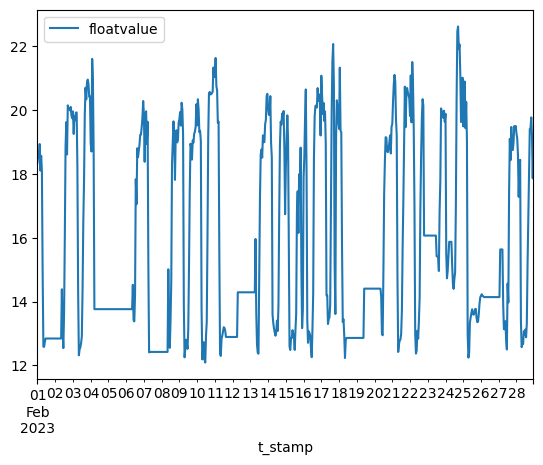

In [ ]:
my_df=df.set_index('t_stamp').resample("H").mean()
my_df.fillna(method='ffill', inplace=True)
my_df.plot()

In [ ]:
my_final_df= my_df.reset_index()[['t_stamp','floatvalue']].rename({'t_stamp':'ds','floatvalue':'floatvalue'},axis='columns')
my_final_df

,ds,floatvalue
0,2023-02-01 00:00:00,18.356562
1,2023-02-01 01:00:00,18.710471
2,2023-02-01 02:00:00,18.498388
3,2023-02-01 03:00:00,18.938417
4,2023-02-01 04:00:00,18.105812
...,...,...
667,2023-02-28 19:00:00,19.436618
668,2023-02-28 20:00:00,19.771868
669,2023-02-28 21:00:00,19.172429
670,2023-02-28 22:00:00,17.864043


In [ ]:
train_data=my_final_df[['floatvalue']]
train_data

,floatvalue
0,18.356562
1,18.710471
2,18.498388
3,18.938417
4,18.105812
...,...
667,19.436618
668,19.771868
669,19.172429
670,17.864043


In [ ]:
#split a univariate sequence into samples
def df_to_X_y(sequence, n_steps_in, n_steps_out):
 X, y = list(), list()
 for i in range(len(sequence)-n_steps_in-n_steps_out-1):
 # find the end of this pattern
  end_ix = i + n_steps_in
  out_end_ix = end_ix + n_steps_out
   # gather input and output parts of the pattern
  seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
  X.append(seq_x)
  y.append(seq_y)
 return np.array(X), np.array(y)

In [ ]:
input_size = 36
output_size = 12
X, y = df_to_X_y(train_data, input_size, output_size)
X.shape, y.shape

((623, 36, 1), (623, 12, 1))

In [ ]:
X

array([[[18.35656231],
        [18.71047106],
        [18.49838842],
        ...,
        [14.38717252],
        [13.08428952],
        [12.54372204]],

       [[18.71047106],
        [18.49838842],
        [18.93841708],
        ...,
        [13.08428952],
        [12.54372204],
        [13.64133465]],

       [[18.49838842],
        [18.93841708],
        [18.10581239],
        ...,
        [12.54372204],
        [13.64133465],
        [16.0555921 ]],

       ...,

       [[14.14256096],
        [14.14256096],
        [14.14256096],
        ...,
        [18.44319057],
        [13.40362901],
        [12.57381815]],

       [[14.14256096],
        [14.14256096],
        [14.14256096],
        ...,
        [13.40362901],
        [12.57381815],
        [12.67732277]],

       [[14.14256096],
        [14.14256096],
        [14.14256096],
        ...,
        [12.57381815],
        [12.67732277],
        [12.67732277]]])

In [ ]:
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
X.shape

(623, 36, 1)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [ ]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(input_size, n_features)))
model.add(Dense(output_size))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100)               40800     
                                                                 
 dense_3 (Dense)             (None, 12)                1212      
                                                                 
Total params: 42,012
Trainable params: 42,012
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cp = ModelCheckpoint('model/', save_best_only =True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.005), metrics = [RootMeanSquaredError()])
model.fit(X, y, epochs=50, callbacks = [cp])

Epoch 1/50
19/20 [===========================>..] - ETA: 0s - loss: 268.8175 - root_mean_squared_error: 16.3957

20/20 [==============================] - 2s 29ms/step - loss: 264.7470 - root_mean_squared_error: 16.2710
Epoch 2/50
19/20 [===========================>..] - ETA: 0s - loss: 25.1438 - root_mean_squared_error: 5.0144

20/20 [==============================] - 1s 29ms/step - loss: 24.7804 - root_mean_squared_error: 4.9780
Epoch 3/50
19/20 [===========================>..] - ETA: 0s - loss: 14.3800 - root_mean_squared_error: 3.7921

20/20 [==============================] - 1s 29ms/step - loss: 14.2669 - root_mean_squared_error: 3.7772
Epoch 4/50
19/20 [===========================>..] - ETA: 0s - loss: 9.6109 - root_mean_squared_error: 3.1002

20/20 [==============================] - 1s 43ms/step - loss: 9.6001 - root_mean_squared_error: 3.0984
Epoch 5/50
19/20 [===========================>..] - ETA: 0s - loss: 9.1055 - root_mean_squared_error: 3.0175

20/20 [==============================] - 1s 43ms/step - loss: 9.1681 - root_mean_squared_error: 3.0279
Epoch 6/50
19/20 [===========================>..] - ETA: 0s - loss: 8.9650 - root_mean_squared_error: 2.9942

20/20 [==============================] - 1s 44ms/step - loss: 8.9745 - root_mean_squared_error: 2.9957
Epoch 7/50
19/20 [===========================>..] - ETA: 0s - loss: 426154560.0000 - root_mean_squared_error: 20643.5117

20/20 [==============================] - 1s 47ms/step - loss: 415898752.0000 - root_mean_squared_error: 20393.5977
Epoch 8/50
20/20 [==============================] - ETA: 0s - loss: 903308032.0000 - root_mean_squared_error: 30055.0840

20/20 [==============================] - 1s 45ms/step - loss: 903308032.0000 - root_mean_squared_error: 30055.0840
Epoch 9/50
20/20 [==============================] - ETA: 0s - loss: 317633280.0000 - root_mean_squared_error: 17822.2676

20/20 [==============================] - 1s 35ms/step - loss: 317633280.0000 - root_mean_squared_error: 17822.2676
Epoch 10/50
19/20 [===========================>..] - ETA: 0s - loss: 524.2111 - root_mean_squared_error: 22.8957

20/20 [==============================] - 1s 29ms/step - loss: 517.9802 - root_mean_squared_error: 22.7592
Epoch 11/50
19/20 [===========================>..] - ETA: 0s - loss: 1456.3896 - root_mean_squared_error: 38.1627

20/20 [==============================] - 1s 29ms/step - loss: 1453.1167 - root_mean_squared_error: 38.1198
Epoch 12/50
19/20 [===========================>..] - ETA: 0s - loss: 42658.8281 - root_mean_squared_error: 206.5401

20/20 [==============================] - 1s 29ms/step - loss: 41665.2344 - root_mean_squared_error: 204.1207
Epoch 13/50
19/20 [===========================>..] - ETA: 0s - loss: 3437.1384 - root_mean_squared_error: 58.6271

20/20 [==============================] - 1s 29ms/step - loss: 3384.6953 - root_mean_squared_error: 58.1781
Epoch 14/50
19/20 [===========================>..] - ETA: 0s - loss: 875.9802 - root_mean_squared_error: 29.5970

20/20 [==============================] - 1s 29ms/step - loss: 869.3611 - root_mean_squared_error: 29.4849
Epoch 15/50
19/20 [===========================>..] - ETA: 0s - loss: 559.1707 - root_mean_squared_error: 23.6468

20/20 [==============================] - 1s 29ms/step - loss: 556.6028 - root_mean_squared_error: 23.5924
Epoch 16/50
19/20 [===========================>..] - ETA: 0s - loss: 373.0823 - root_mean_squared_error: 19.3153

20/20 [==============================] - 1s 29ms/step - loss: 371.1661 - root_mean_squared_error: 19.2657
Epoch 17/50
19/20 [===========================>..] - ETA: 0s - loss: 212.5846 - root_mean_squared_error: 14.5803

20/20 [==============================] - 1s 28ms/step - loss: 211.0114 - root_mean_squared_error: 14.5262
Epoch 18/50
19/20 [===========================>..] - ETA: 0s - loss: 95.0854 - root_mean_squared_error: 9.7512

20/20 [==============================] - 1s 29ms/step - loss: 94.1679 - root_mean_squared_error: 9.7040
Epoch 19/50
19/20 [===========================>..] - ETA: 0s - loss: 51.4189 - root_mean_squared_error: 7.1707

20/20 [==============================] - 1s 30ms/step - loss: 51.2425 - root_mean_squared_error: 7.1584
Epoch 20/50
19/20 [===========================>..] - ETA: 0s - loss: 34.3884 - root_mean_squared_error: 5.8642

20/20 [==============================] - 1s 29ms/step - loss: 34.2807 - root_mean_squared_error: 5.8550
Epoch 21/50
19/20 [===========================>..] - ETA: 0s - loss: 26.5816 - root_mean_squared_error: 5.1557

20/20 [==============================] - 1s 29ms/step - loss: 26.5548 - root_mean_squared_error: 5.1531
Epoch 22/50
19/20 [===========================>..] - ETA: 0s - loss: 22.7586 - root_mean_squared_error: 4.7706

20/20 [==============================] - 1s 30ms/step - loss: 22.8679 - root_mean_squared_error: 4.7820
Epoch 23/50
19/20 [===========================>..] - ETA: 0s - loss: 21.0257 - root_mean_squared_error: 4.5854

20/20 [==============================] - 1s 30ms/step - loss: 21.1089 - root_mean_squared_error: 4.5944
Epoch 24/50
19/20 [===========================>..] - ETA: 0s - loss: 20.2052 - root_mean_squared_error: 4.4950

20/20 [==============================] - 1s 28ms/step - loss: 20.2655 - root_mean_squared_error: 4.5017
Epoch 25/50
19/20 [===========================>..] - ETA: 0s - loss: 19.9091 - root_mean_squared_error: 4.4620

20/20 [==============================] - 1s 29ms/step - loss: 19.8906 - root_mean_squared_error: 4.4599
Epoch 26/50
19/20 [===========================>..] - ETA: 0s - loss: 19.6230 - root_mean_squared_error: 4.4298

20/20 [==============================] - 1s 40ms/step - loss: 19.6438 - root_mean_squared_error: 4.4321
Epoch 27/50
19/20 [===========================>..] - ETA: 0s - loss: 19.6476 - root_mean_squared_error: 4.4326

20/20 [==============================] - 1s 43ms/step - loss: 19.4950 - root_mean_squared_error: 4.4153
Epoch 28/50
19/20 [===========================>..] - ETA: 0s - loss: 19.2389 - root_mean_squared_error: 4.3862

20/20 [==============================] - 1s 43ms/step - loss: 19.3957 - root_mean_squared_error: 4.4041
Epoch 29/50
19/20 [===========================>..] - ETA: 0s - loss: 19.1279 - root_mean_squared_error: 4.3735

20/20 [==============================] - 1s 43ms/step - loss: 19.3165 - root_mean_squared_error: 4.3951
Epoch 30/50
19/20 [===========================>..] - ETA: 0s - loss: 19.1789 - root_mean_squared_error: 4.3794

20/20 [==============================] - 1s 42ms/step - loss: 19.2707 - root_mean_squared_error: 4.3898
Epoch 31/50
20/20 [==============================] - ETA: 0s - loss: 19.1656 - root_mean_squared_error: 4.3779

20/20 [==============================] - 1s 43ms/step - loss: 19.1656 - root_mean_squared_error: 4.3779
Epoch 32/50
19/20 [===========================>..] - ETA: 0s - loss: 19.0848 - root_mean_squared_error: 4.3686

20/20 [==============================] - 1s 29ms/step - loss: 19.0851 - root_mean_squared_error: 4.3686
Epoch 33/50
19/20 [===========================>..] - ETA: 0s - loss: 18.8248 - root_mean_squared_error: 4.3388

20/20 [==============================] - 1s 29ms/step - loss: 19.0121 - root_mean_squared_error: 4.3603
Epoch 34/50
19/20 [===========================>..] - ETA: 0s - loss: 19.0678 - root_mean_squared_error: 4.3667

20/20 [==============================] - 1s 29ms/step - loss: 18.9578 - root_mean_squared_error: 4.3541
Epoch 35/50
19/20 [===========================>..] - ETA: 0s - loss: 18.8995 - root_mean_squared_error: 4.3474

20/20 [==============================] - 1s 30ms/step - loss: 18.9096 - root_mean_squared_error: 4.3485
Epoch 36/50
19/20 [===========================>..] - ETA: 0s - loss: 18.7914 - root_mean_squared_error: 4.3349

20/20 [==============================] - 1s 30ms/step - loss: 18.8330 - root_mean_squared_error: 4.3397
Epoch 37/50
19/20 [===========================>..] - ETA: 0s - loss: 18.8824 - root_mean_squared_error: 4.3454

20/20 [==============================] - 1s 30ms/step - loss: 18.7930 - root_mean_squared_error: 4.3351
Epoch 38/50
20/20 [==============================] - ETA: 0s - loss: 18.7415 - root_mean_squared_error: 4.3291

20/20 [==============================] - 1s 31ms/step - loss: 18.7415 - root_mean_squared_error: 4.3291
Epoch 39/50
19/20 [===========================>..] - ETA: 0s - loss: 18.7858 - root_mean_squared_error: 4.3343

20/20 [==============================] - 1s 29ms/step - loss: 18.6842 - root_mean_squared_error: 4.3225
Epoch 40/50
19/20 [===========================>..] - ETA: 0s - loss: 18.5041 - root_mean_squared_error: 4.3016

20/20 [==============================] - 1s 29ms/step - loss: 18.6361 - root_mean_squared_error: 4.3170
Epoch 41/50
19/20 [===========================>..] - ETA: 0s - loss: 18.6856 - root_mean_squared_error: 4.3227

20/20 [==============================] - 1s 29ms/step - loss: 18.6538 - root_mean_squared_error: 4.3190
Epoch 42/50
19/20 [===========================>..] - ETA: 0s - loss: 18.5820 - root_mean_squared_error: 4.3107

20/20 [==============================] - 1s 29ms/step - loss: 18.6364 - root_mean_squared_error: 4.3170
Epoch 43/50
19/20 [===========================>..] - ETA: 0s - loss: 18.6366 - root_mean_squared_error: 4.3170

20/20 [==============================] - 1s 30ms/step - loss: 18.5539 - root_mean_squared_error: 4.3074
Epoch 44/50
19/20 [===========================>..] - ETA: 0s - loss: 18.3777 - root_mean_squared_error: 4.2869

20/20 [==============================] - 1s 28ms/step - loss: 18.4726 - root_mean_squared_error: 4.2980
Epoch 45/50
19/20 [===========================>..] - ETA: 0s - loss: 18.5187 - root_mean_squared_error: 4.3033

20/20 [==============================] - 1s 30ms/step - loss: 18.4517 - root_mean_squared_error: 4.2955
Epoch 46/50
19/20 [===========================>..] - ETA: 0s - loss: 18.5323 - root_mean_squared_error: 4.3049

20/20 [==============================] - 1s 30ms/step - loss: 18.4395 - root_mean_squared_error: 4.2941
Epoch 47/50
19/20 [===========================>..] - ETA: 0s - loss: 18.3314 - root_mean_squared_error: 4.2815

20/20 [==============================] - 1s 30ms/step - loss: 18.4320 - root_mean_squared_error: 4.2932
Epoch 48/50
20/20 [==============================] - ETA: 0s - loss: 18.3899 - root_mean_squared_error: 4.2883

20/20 [==============================] - 1s 33ms/step - loss: 18.3899 - root_mean_squared_error: 4.2883
Epoch 49/50
19/20 [===========================>..] - ETA: 0s - loss: 18.4746 - root_mean_squared_error: 4.2982

20/20 [==============================] - 1s 44ms/step - loss: 18.3890 - root_mean_squared_error: 4.2882
Epoch 50/50
20/20 [==============================] - ETA: 0s - loss: 18.2983 - root_mean_squared_error: 4.2777

20/20 [==============================] - 1s 45ms/step - loss: 18.2983 - root_mean_squared_error: 4.2777


In [ ]:
yhat=list()
for half_day in range(52):
  x_input = X[12*half_day].reshape((1, input_size, n_features))
  yhat.append(model.predict(x_input))



1/1 [==============================] - 0s 27ms/step


In [ ]:
yhat_df = pd.DataFrame(np.array(yhat).flatten(), columns = ['yhat'])

In [ ]:
yhat_df

,yhat
0,15.480156
1,15.251646
2,15.568432
3,15.828644
4,15.193152
...,...
619,13.171495
620,13.661772
621,13.548859
622,13.844753


In [ ]:
#x_input = X[-1].reshape((1, input_size, n_features))
#yhat = model.predict(x_input)
#yhat_df = pd.DataFrame(np.transpose(yhat), columns = ['yhat'])

In [ ]:
import pandas as pd 
yhat_times = pd.date_range('2023-02-01', periods=624, freq='1H')

In [ ]:
yhat_df['t_stamp']=yhat_times
yhat_df

,yhat,t_stamp
0,15.480156,2023-02-01 00:00:00
1,15.251646,2023-02-01 01:00:00
2,15.568432,2023-02-01 02:00:00
3,15.828644,2023-02-01 03:00:00
4,15.193152,2023-02-01 04:00:00
...,...,...
619,13.171495,2023-02-26 19:00:00
620,13.661772,2023-02-26 20:00:00
621,13.548859,2023-02-26 21:00:00
622,13.844753,2023-02-26 22:00:00


In [87]:
import plotly.express as px
import plotly.graph_objects as go
df = px.data.iris()

fig1 = px.line(my_final_df, x="ds", y="floatvalue")
fig1.update_traces(line=dict(color = 'blue'))

fig2 = px.line(yhat_df, x="t_stamp", y="yhat")
fig2.update_traces(line=dict(color = 'red'))

fig3 = go.Figure(data=fig1.data + fig2.data)
fig3.show()